<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Семинар 1: практическое занятие по обучению нейросетей (датасет CIFAR10)</b></h2>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

import multiprocessing

Сегодня мы построим свою сеть (простейший классификатор изображений), посчитаем loss и проведем обновление весов.


Данные
----------------
Мы будем работать с набором картинок. Для работы с ними есть специальный пакет ``torchvision``. В нем уже содержатся функции-загрузчики таких датасетов, как ImageNet, MNIST, CIFAR10. С последним сегодня мы и будем работать. В нем содержатся картинки RGB 32х32 следующих классов: 
1. ‘airplane’
2. ‘automobile’
3. ‘bird’
4. ‘cat’
5. ‘deer’
6. ‘dog’
7. ‘frog’
8. ‘horse’
9. ‘ship’
10. ‘truck’

Обучение классификатора
----------------------------

План обучения классификатора:

1. Загружаем и нормализуем данные при помощи пакета
   ``torchvision``
2. Объявляем нейронную сети
3. Объявляем функцию потерь
4. Тренируем сеть при помощи тренировочной выборки (train data)
5. Тестируем сеть при помощи валидационной выборки (test data)

----------------------------

Импортируем нужные нам пакеты из библиотеки ``torch``




In [0]:
import torch
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

В результате загрузки датасетов при помощи пакета torchvision мы получим картинки, содержащие значения в диапазоне [0,1], чтобы подавать их в нейросеть, нам нужно сделать из них тензоры со значениями в диапазоне [-1,1]

Определим презобразование:

In [0]:
transform = transforms.Compose(
    
[
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

)

Теперь вызовем загрузчики из пакета ``torchvision`` и скачаем обучающую выборку (trainset) и валидационную (testset)



In [7]:
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                           shuffle=True, num_workers=0, pin_memory=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                                shuffle=False, num_workers=0, pin_memory=False)

Files already downloaded and verified


Определим константы

In [0]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
COLOR_CHANNELS = 3
EPOCHS = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 32
BATCH_IMAGE_COUNT = 10000
CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
N_CLASSES = len(CLASSES)
PLOT = False

 frog   dog  deer  deer


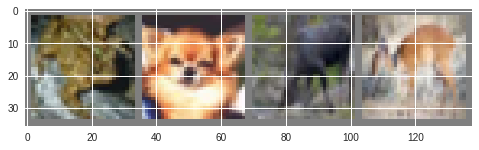

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Функция, которая показывает изображения
def imshow(img):
    img = img / 2 + 0.5     # деномрировка
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# достаем случайные картинки из обучающей выборки
dataiter = iter(train_loader)
images, labels = dataiter.next()

# вызываем функцию, реализующую демонстрацию изображений, что мы можем видеть на них?
imshow(torchvision.utils.make_grid(images))
# выведем метки классов отрисованных изображений
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(4)))

In [0]:
class Net(torch.nn.Module):
    def __init__(self, n_hidden_nodes, n_hidden_layers):
        super(Net, self).__init__()
        # Определяем слои
        self.fc1 = torch.nn.Linear(IMAGE_WIDTH * IMAGE_WIDTH * COLOR_CHANNELS,
                                   n_hidden_nodes)
#         self.n_hidden_nodes=n_hidden_nodes
#         self.n_hidden_layers=n_hidden_layers

        self.out = torch.nn.Linear(n_hidden_nodes, N_CLASSES)

    def forward(self, x):
        x = x.view(-1, IMAGE_WIDTH * IMAGE_WIDTH * COLOR_CHANNELS)
        # определяем функцию активации
        sigmoid = torch.nn.Sigmoid()
        x = sigmoid(self.fc1(x))
        return torch.nn.functional.log_softmax(self.out(x))

In [0]:
def train(epoch, model, train_loader, optimizer, log_interval=100, cuda=None):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)

        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(train_loader.dataset)
        
        
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0], accuracy))


In [0]:
def validate(loss_vector, accuracy_vector, model, validation_loader, cuda=None):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += torch.nn.functional.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [0]:
from tqdm import tqdm_notebook

In [0]:
hidden_nodes = 10
layers = 1
model = Net(hidden_nodes, layers)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_vector = []
acc_vector = []
for epoch in range(1, EPOCHS + 1):
    train(epoch, model, train_loader, optimizer, cuda=cuda)
    validate(loss_vector, acc_vector, model, validation_loader, cuda=cuda)
    if epoch == 40:
        break

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.280676
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.914732

Validation set: Average loss: 2.0466, Accuracy: 2958/10000 (29%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.179598
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.652516

Validation set: Average loss: 1.9539, Accuracy: 3169/10000 (31%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.011090
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.491545

Validation set: Average loss: 1.9037, Accuracy: 3372/10000 (33%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.427091
Train Epoch: 4 [40000/50000 (80%)]	Loss: 1.998777

Validation set: Average loss: 1.8686, Accuracy: 3473/10000 (34%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.828201
Train Epoch: 5 [40000/50000 (80%)]	Loss: 1.832490

Validation set: Average loss: 1.8426, Accuracy: 3544/10000 (35%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 2.105319
Train Epoch: 6 [40000/50000 (80%)]	Loss: 1.861091

Validation set: Average loss: 1.8188, Accuracy: 3633/10000 (36%)

Train Epoch: 7 [0/50000 (0%)

Итак, мы обучили нашу сеть проходами по обучающей выборке. Давайте проверим, обучилась ли наша сеть. Проверим это путем предсказания меток классов для валидационной выборки.

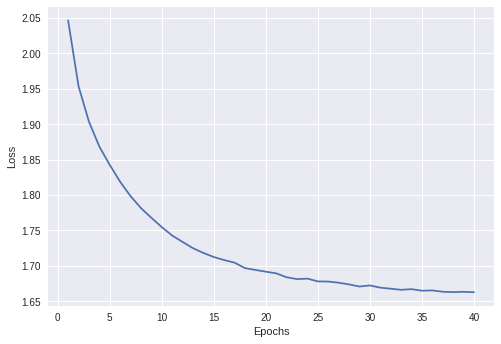

In [0]:
# Plot train loss and validation accuracy vs epochs for each learning rate
epochs = [i for i in range(1, 41)]
plt.plot(epochs, loss_vector)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

GroundTruth:    cat  ship  ship plane


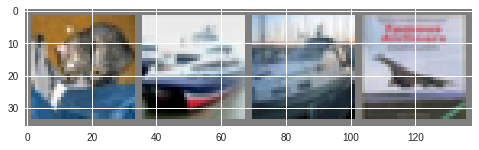

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()

# выведем наши предсказания
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % CLASSES[labels[j]] for j in range(4)))

outputs=model(images)

In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % CLASSES[predicted[j]]
                              for j in range(4)))

Predicted:    dog truck  ship plane


Протестируем на всем тесте:

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 41 %


In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        CLASSES[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 49 %
Accuracy of  bird : 15 %
Accuracy of   cat : 21 %
Accuracy of  deer : 35 %
Accuracy of   dog : 31 %
Accuracy of  frog : 59 %
Accuracy of horse : 48 %
Accuracy of  ship : 56 %
Accuracy of truck : 48 %


Каким образом мы можем улучшить качество распознавания и обучения?
1. Добавить **dropout**

2. Добавить **batchnorm** (2 семинар)
3. Использовать свертки. Но об этом позже :)

In [0]:
class SecondNet(torch.nn.Module):
    def __init__(self, n_hidden_nodes, n_hidden_layers,keep_rate=0.8):
        super().__init__()
        self.n_hidden_nodes = n_hidden_nodes
        self.n_hidden_layers = n_hidden_layers
#         if not keep_rate:
#             keep_rate = 0.5
#         self.keep_rate = keep_rate
        # Set up perceptron layers and add dropout
        self.fc1 = torch.nn.Linear(IMAGE_WIDTH * IMAGE_WIDTH * COLOR_CHANNELS,
                                   self.n_hidden_nodes)
        self.fc1_drop = torch.nn.Dropout(1 - keep_rate)
        self.out = torch.nn.Linear(self.n_hidden_nodes, N_CLASSES)
    
    def forward(self, x):
        x = x.view(-1, IMAGE_WIDTH * IMAGE_WIDTH * COLOR_CHANNELS)
        sigmoid = torch.nn.Sigmoid()
        x = sigmoid(self.fc1(x))
        x = self.fc1_drop(x)
        return torch.nn.functional.log_softmax(self.out(x))


In [0]:
В Pytorch есть возможность запускать вычисления на GPU

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.338229
Train Epoch: 1 [40000/50000 (80%)]	Loss: 2.356363

Validation set: Average loss: 1.9368, Accuracy: 3253/10000 (32%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.300326
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.809654

Validation set: Average loss: 1.8590, Accuracy: 3606/10000 (36%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.370393
Train Epoch: 3 [40000/50000 (80%)]	Loss: 1.909336

Validation set: Average loss: 1.8124, Accuracy: 3713/10000 (37%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.186283
Train Epoch: 4 [40000/50000 (80%)]	Loss: 2.361922

Validation set: Average loss: 1.7815, Accuracy: 3809/10000 (38%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.897958
Train Epoch: 5 [40000/50000 (80%)]	Loss: 1.988269

Validation set: Average loss: 1.7591, Accuracy: 3885/10000 (38%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.896815
Train Epoch: 6 [40000/50000 (80%)]	Loss: 1.614118

Validation set: Average loss: 1.7428, Accuracy: 3922/10000 (39%)

Train Epoch: 7 [0/50000 (0%)

In [0]:
# to save model use torch.save(model.state_dict(), 'Second_Net.pt') 
# to load use model.load_state_dict(torch.load('Second_Model.pt'))

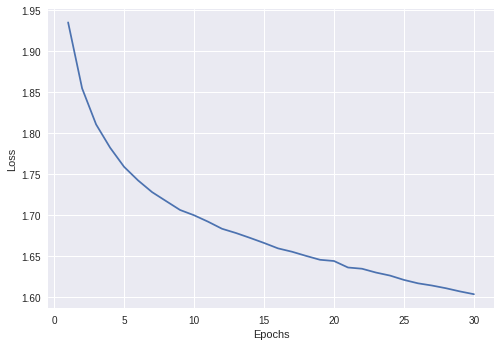

In [0]:
# Plot train loss and validation accuracy vs epochs for each learning rate
epochs = [i for i in range(1, 31)]
plt.plot(epochs, loss_vector)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Попробуйте самостоятельно написать двуслойную сеть с дропаутом. Получилось ли улучшить результат?

In [0]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, n_hidden_nodes, n_hidden_layers,keep_rate=0):
        super(TwoLayerNet, self).__init__()
        self.n_hidden_nodes = n_hidden_nodes
        self.n_hidden_layers = n_hidden_layers
        if not keep_rate:
            keep_rate = 0.5
        self.keep_rate = keep_rate
        # Set up perceptron layers and add dropout
        self.fc1 = torch.nn.Linear(IMAGE_WIDTH * IMAGE_WIDTH * COLOR_CHANNELS,
                                   n_hidden_nodes)
        self.fc1_drop = torch.nn.Dropout(1 - keep_rate)
        if n_hidden_layers == 2:
            self.fc2 = #тут ваш код
            self.fc2_drop = #тут ваш код

        self.out = torch.nn.Linear(n_hidden_nodes, N_CLASSES)
    
    def forward(self, x):
        x = x.view(-1, IMAGE_WIDTH * IMAGE_WIDTH * COLOR_CHANNELS)
        sigmoid = torch.nn.Sigmoid()
        #тут ваш код
        return torch.nn.functional.log_softmax(self.out(x))

In [0]:
<Ваш код здесь>